# 🏠 Google Reviews Exploratory Data Analysis

- Demo for BADM 590
- Ye Joo Park and Unnati Narang

In this demo, we will compare how the property management companies in Champaign-Urbana area compare to those of two other campustowns - Provo, UT and State College, PA.

In [ ]:
# run this code cell before any other cell
# install pandas 2.2.0 if in colab environment
import sys

if 'google.colab' in sys.modules:
  !pip install pandas==2.2.0

In [1]:
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
from plotly.subplots import make_subplots

In [2]:
import plotly

print(f'pandas version: {pd.__version__}')
print(f'plotly version: {plotly.__version__}')

pandas version: 2.1.2
plotly version: 5.18.0


Set the nubmer of maximum number of displayed columns to 50.

In [3]:
pd.set_option('display.max_columns', 50)

## Load Data

There are four tables.

- `df_b`: List of property management companies or apartments
- `df_r`: Google reviews of the property management companies or apartments
- `df_tokens`: Tokenized result of reviews using spaCy
- `df_sentiments`: Sentiment analysis result using DistilBERT

In [4]:
df_b = pd.read_csv('https://github.com/bdi475/datasets/raw/main/campustowns-leasing-company-reviews/results/businesses.csv')
df_r = pd.read_csv(
    'https://github.com/bdi475/datasets/raw/main/campustowns-leasing-company-reviews/results/reviews.csv',
    parse_dates = ['review_datetime_utc', 'owner_answer_timestamp_datetime_utc']
)
df_tokens = pd.read_csv('https://github.com/bdi475/datasets/raw/main/campustowns-leasing-company-reviews/results/tokens.csv.gz')
df_sentiments = pd.read_csv('https://github.com/bdi475/datasets/raw/main/campustowns-leasing-company-reviews/results/sentiments.csv')

## Preprocess Data

### Businesses dataset

Display the businesses table.

In [5]:
df_b.head()

campus                     place_id  \
0  Brigham Young University  ChIJqyXyo6GQTYcRXGfgeIpqc_I   
1  Brigham Young University  ChIJGbnTbamQTYcRtZfBrL52jhs   
2  Brigham Young University  ChIJaURIj6GQTYcRCY56AtxjTI4   
3  Brigham Young University  ChIJU6EhynuRTYcRv5tkFZYZ8k0   
4  Brigham Young University  ChIJaURIj6GQTYcRkndi2c5Rtdw   

                   name                                               site  \
0        Alpine Village                       https://myalpinevillage.com/   
1  Palladium Apartments                    https://www.palladiumprovo.com/   
2   Glenwood Apartments                           https://glenwoodapt.com/   
3           Campus Edge               https://campusprovo.com/campus-edge/   
4  Cambridge Apartments  https://www.cambridgecourtapt.com/?switch_cls[...   

                 category      borough                   street   city  \
0  Student housing center  Carterville  1378 Freedom Blvd 200 W  Provo   
1         Housing complex   North Park  538 N Freedom Blvd Unit  Provo   
2  Student housing center  Carterville    1565 N University Ave  Provo   
3  Student housing center  Carterville         1305 N Canyon Rd  Provo   
4       Apartment complex  Carterville    1425 N University Ave  Provo   

   postal_code state   latitude   longitude  verified  
0        84604  Utah  40.252607 -111.661247      True  
1        84601  Utah  40.240917 -111.661714      True  
2        84604  Utah  40.254606 -111.659193      True  
3        84604  Utah  40.251654 -111.656401      True  
4        84604  Utah  40.253127 -111.659800      True

In [6]:
print(f"There are {df_b.shape[0]} rows and {df_b.shape[1]} columns in the businesses table.")

There are 142 rows and 13 columns in the businesses table.


Print out the DataFrame's information.

In [7]:
df_b.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 142 entries, 0 to 141
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   campus       142 non-null    object 
 1   place_id     142 non-null    object 
 2   name         142 non-null    object 
 3   site         140 non-null    object 
 4   category     142 non-null    object 
 5   borough      71 non-null     object 
 6   street       142 non-null    object 
 7   city         142 non-null    object 
 8   postal_code  142 non-null    int64  
 9   state        142 non-null    object 
 10  latitude     142 non-null    float64
 11  longitude    142 non-null    float64
 12  verified     142 non-null    bool   
dtypes: bool(1), float64(2), int64(1), object(9)
memory usage: 13.6+ KB


Check for missing values.

In [8]:
df_b.isna().sum()

campus          0
place_id        0
name            0
site            2
category        0
borough        71
street          0
city            0
postal_code     0
state           0
latitude        0
longitude       0
verified        0
dtype: int64

The "site" and "borough" columns have missing values.

### Reviews dataset

Display the reviews table.

In [9]:
df_r.head()

place_id                             review_id  \
0  ChIJqyXyo6GQTYcRXGfgeIpqc_I  ChdDSUhNMG9nS0VJQ0FnSUQ1OXRHZnNnRRAB   
1  ChIJqyXyo6GQTYcRXGfgeIpqc_I   ChZDSUhNMG9nS0VJQ0FnSUNwOUstOVpBEAE   
2  ChIJqyXyo6GQTYcRXGfgeIpqc_I   ChZDSUhNMG9nS0VJQ0FnSURwbGZXTUJ3EAE   
3  ChIJqyXyo6GQTYcRXGfgeIpqc_I  ChdDSUhNMG9nS0VJQ0FnSURwdzd1Q3B3RRAB   
4  ChIJqyXyo6GQTYcRXGfgeIpqc_I   ChZDSUhNMG9nS0VJQ0FnSURKdnFxeWVnEAE   

               author_id    author_title  \
0  100512067005706825621     Laura Brown   
1  102936107836751613731  Pete Haraguchi   
2  103835714740882872235    Jack Radford   
3  107352000345615085703  Daniel Merritt   
4  109184252255204802361   Carman Hansen   

                                         review_text  review_rating  \
0  Service requests take a very long time to be r...              3   
1  I was thinking about giving two stars but I le...              1   
2  DO NOT LIVE HERE. This was the WORST experienc...              1   
3  If you have any other choice, take it over Alp...              1   
4  Honestly, I debated whether or not I should le...              1   

                                      review_img_url  \
0                                                NaN   
1  https://lh5.googleusercontent.com/p/AF1QipPeIy...   
2                                                NaN   
3                                                NaN   
4                                                NaN   

        review_datetime_utc  \
0 2023-10-24 12:46:43+00:00   
1 2023-07-29 20:30:26+00:00   
2 2023-08-26 03:31:42+00:00   
3 2023-08-28 21:54:09+00:00   
4 2023-07-17 21:47:22+00:00   

                                        owner_answer  \
0  Dear Laura, \n\n We hear you loud and clear, t...   
1  Pete,\n\n Thank you for letting us know about ...   
2  Jack, \n\n I’m so sorry — it sounds like we re...   
3  Daniel,\n\n Even though it was a negative expe...   
4  Dear Carman, \n\n Thank you for bringing this ...   

  owner_answer_timestamp_datetime_utc  review_likes  
0           2023-10-24 14:56:01+00:00             0  
1           2023-07-29 22:46:48+00:00            12  
2           2023-08-26 04:56:04+00:00             3  
3           2023-08-29 00:00:30+00:00             4  
4           2023-07-17 22:59:16+00:00             9

In [10]:
print(f"There are {df_r.shape[0]} rows and {df_r.shape[1]} columns in the reviews table.")

There are 16848 rows and 11 columns in the reviews table.


Check for missing values.

In [11]:
df_r.isna().sum()

place_id                                   0
review_id                                  0
author_id                                  0
author_title                               0
review_text                             1969
review_rating                              0
review_img_url                         16478
review_datetime_utc                        0
owner_answer                            6951
owner_answer_timestamp_datetime_utc     6951
review_likes                               0
dtype: int64

Columns "review_text", "review_img_url", "owner_answer", and "owner_answer_timestamp_datetime_utc" have missing values.

### Sentiments

Display the sentiments table.

In [12]:
df_sentiments.head()

review_id sentiment     score
0  ChdDSUhNMG9nS0VJQ0FnSUQ1OXRHZnNnRRAB  POSITIVE  0.909106
1   ChZDSUhNMG9nS0VJQ0FnSUNwOUstOVpBEAE  NEGATIVE  0.999216
2   ChZDSUhNMG9nS0VJQ0FnSURwbGZXTUJ3EAE  NEGATIVE  0.998690
3  ChdDSUhNMG9nS0VJQ0FnSURwdzd1Q3B3RRAB  NEGATIVE  0.999131
4   ChZDSUhNMG9nS0VJQ0FnSURKdnFxeWVnEAE  NEGATIVE  0.999204

Check for missing values.

In [13]:
df_sentiments.isna().sum()

review_id    0
sentiment    0
score        0
dtype: int64

There are no missing values in the sentiments table.

#### Merge sentiments into reviews

In [14]:
if 'sentiment' not in df_r.columns:
    df_r = pd.merge(
        left=df_r,
        right=df_sentiments,
        on='review_id',
        how='left'
    )

df_r.head()

place_id                             review_id  \
0  ChIJqyXyo6GQTYcRXGfgeIpqc_I  ChdDSUhNMG9nS0VJQ0FnSUQ1OXRHZnNnRRAB   
1  ChIJqyXyo6GQTYcRXGfgeIpqc_I   ChZDSUhNMG9nS0VJQ0FnSUNwOUstOVpBEAE   
2  ChIJqyXyo6GQTYcRXGfgeIpqc_I   ChZDSUhNMG9nS0VJQ0FnSURwbGZXTUJ3EAE   
3  ChIJqyXyo6GQTYcRXGfgeIpqc_I  ChdDSUhNMG9nS0VJQ0FnSURwdzd1Q3B3RRAB   
4  ChIJqyXyo6GQTYcRXGfgeIpqc_I   ChZDSUhNMG9nS0VJQ0FnSURKdnFxeWVnEAE   

               author_id    author_title  \
0  100512067005706825621     Laura Brown   
1  102936107836751613731  Pete Haraguchi   
2  103835714740882872235    Jack Radford   
3  107352000345615085703  Daniel Merritt   
4  109184252255204802361   Carman Hansen   

                                         review_text  review_rating  \
0  Service requests take a very long time to be r...              3   
1  I was thinking about giving two stars but I le...              1   
2  DO NOT LIVE HERE. This was the WORST experienc...              1   
3  If you have any other choice, take it over Alp...              1   
4  Honestly, I debated whether or not I should le...              1   

                                      review_img_url  \
0                                                NaN   
1  https://lh5.googleusercontent.com/p/AF1QipPeIy...   
2                                                NaN   
3                                                NaN   
4                                                NaN   

        review_datetime_utc  \
0 2023-10-24 12:46:43+00:00   
1 2023-07-29 20:30:26+00:00   
2 2023-08-26 03:31:42+00:00   
3 2023-08-28 21:54:09+00:00   
4 2023-07-17 21:47:22+00:00   

                                        owner_answer  \
0  Dear Laura, \n\n We hear you loud and clear, t...   
1  Pete,\n\n Thank you for letting us know about ...   
2  Jack, \n\n I’m so sorry — it sounds like we re...   
3  Daniel,\n\n Even though it was a negative expe...   
4  Dear Carman, \n\n Thank you for bringing this ...   

  owner_answer_timestamp_datetime_utc  review_likes sentiment     score  
0           2023-10-24 14:56:01+00:00             0  POSITIVE  0.909106  
1           2023-07-29 22:46:48+00:00            12  NEGATIVE  0.999216  
2           2023-08-26 04:56:04+00:00             3  NEGATIVE  0.998690  
3           2023-08-29 00:00:30+00:00             4  NEGATIVE  0.999131  
4           2023-07-17 22:59:16+00:00             9  NEGATIVE  0.999204

### Tokens

Display the list of tokens in its original form (`"text"`), lemmatized form (`"lemma"`), and their part of speech explanations (`"explain"`).

In [15]:
df_tokens

review_id        text      lemma    explain
0       ChdDSUhNMG9nS0VJQ0FnSUQ1OXRHZnNnRRAB     Service    service       noun
1       ChdDSUhNMG9nS0VJQ0FnSUQ1OXRHZnNnRRAB    requests    request       noun
2       ChdDSUhNMG9nS0VJQ0FnSUQ1OXRHZnNnRRAB        long       long  adjective
3       ChdDSUhNMG9nS0VJQ0FnSUQ1OXRHZnNnRRAB        time       time       noun
4       ChdDSUhNMG9nS0VJQ0FnSUQ1OXRHZnNnRRAB   responded    respond       verb
...                                      ...         ...        ...        ...
533659   ChZDSUhNMG9nS0VJQ0FnSURBdHNiMWRnEAE     looking       look       verb
533660   ChZDSUhNMG9nS0VJQ0FnSURBdHNiMWRnEAE  apartments  apartment       noun
533661   ChZDSUhNMG9nS0VJQ0FnSURBdHNiMWRnEAE    answered     answer       verb
533662   ChZDSUhNMG9nS0VJQ0FnSURBdHNiMWRnEAE   questions   question       noun
533663   ChZDSUhNMG9nS0VJQ0FnSURBdHNiMWRnEAE     patient    patient  adjective

[533664 rows x 4 columns]

### Merge reviews and businesses

In [16]:
df_m = pd.merge(
    left=df_r,
    right=df_b,
    on='place_id',
    how='inner'
)

df_m.head(2)

place_id                             review_id  \
0  ChIJqyXyo6GQTYcRXGfgeIpqc_I  ChdDSUhNMG9nS0VJQ0FnSUQ1OXRHZnNnRRAB   
1  ChIJqyXyo6GQTYcRXGfgeIpqc_I   ChZDSUhNMG9nS0VJQ0FnSUNwOUstOVpBEAE   

               author_id    author_title  \
0  100512067005706825621     Laura Brown   
1  102936107836751613731  Pete Haraguchi   

                                         review_text  review_rating  \
0  Service requests take a very long time to be r...              3   
1  I was thinking about giving two stars but I le...              1   

                                      review_img_url  \
0                                                NaN   
1  https://lh5.googleusercontent.com/p/AF1QipPeIy...   

        review_datetime_utc  \
0 2023-10-24 12:46:43+00:00   
1 2023-07-29 20:30:26+00:00   

                                        owner_answer  \
0  Dear Laura, \n\n We hear you loud and clear, t...   
1  Pete,\n\n Thank you for letting us know about ...   

  owner_answer_timestamp_datetime_utc  review_likes sentiment     score  \
0           2023-10-24 14:56:01+00:00             0  POSITIVE  0.909106   
1           2023-07-29 22:46:48+00:00            12  NEGATIVE  0.999216   

                     campus            name                          site  \
0  Brigham Young University  Alpine Village  https://myalpinevillage.com/   
1  Brigham Young University  Alpine Village  https://myalpinevillage.com/   

                 category      borough                   street   city  \
0  Student housing center  Carterville  1378 Freedom Blvd 200 W  Provo   
1  Student housing center  Carterville  1378 Freedom Blvd 200 W  Provo   

   postal_code state   latitude   longitude  verified  
0        84604  Utah  40.252607 -111.661247      True  
1        84604  Utah  40.252607 -111.661247      True

### 👉 Number of apartments listed by campus

In [17]:
df_b['campus'] \
    .value_counts() \
    .to_frame() \
    .reset_index()

campus  count
0                 Brigham Young University     53
1               Penn State University Park     47
2  University of Illinois Urbana-Champaign     42

### 👉 Calculate the time owner took to respond to a review

In [18]:
td = df_m['owner_answer_timestamp_datetime_utc'] - df_m['review_datetime_utc']
response_time_in_days = td.apply(lambda x: x / pd.Timedelta(days=1))

# round the response time if a positive number
# if the resposne time is negative, there is no way of knowing
# when the author has 
df_m['response_time_in_days'] = np.where(
    response_time_in_days > 0,
    round(response_time_in_days, 0),
    response_time_in_days
)

df_m[['review_id', 'owner_answer_timestamp_datetime_utc', 'review_datetime_utc', 'response_time_in_days']].sample(2)

review_id  \
9993   ChdDSUhNMG9nS0VJQ0FnSUM2MWRuajJnRRAB   
10128  ChdDSUhNMG9nS0VJQ0FnSUNPbVBXQWh3RRAB   

      owner_answer_timestamp_datetime_utc       review_datetime_utc  \
9993            2021-09-13 14:41:50+00:00 2021-09-09 19:31:47+00:00   
10128           2022-06-01 15:56:19+00:00 2022-05-31 20:19:12+00:00   

       response_time_in_days  
9993                     4.0  
10128                    1.0

Add a categorical variable based on the `'response_time_in_days'` variable.

In [19]:
df_m['response_time'] = np.select(
    [
        df_m['response_time_in_days'].between(-10000, 0, inclusive='left'),
        df_m['response_time_in_days'].between(0, 1, inclusive='left'),
        df_m['response_time_in_days'].between(1, 7, inclusive='left'),
        df_m['response_time_in_days'].between(7, 30, inclusive='left'),
        df_m['response_time_in_days'].between(31, 10000, inclusive='left'),
    ],
    [
        'Unknown (review updated)',
        'Within a day',
        'Within a week',
        'Within a month',
        'After a month'
    ],
    default='No response'
)

df_m.head(2)

place_id                             review_id  \
0  ChIJqyXyo6GQTYcRXGfgeIpqc_I  ChdDSUhNMG9nS0VJQ0FnSUQ1OXRHZnNnRRAB   
1  ChIJqyXyo6GQTYcRXGfgeIpqc_I   ChZDSUhNMG9nS0VJQ0FnSUNwOUstOVpBEAE   

               author_id    author_title  \
0  100512067005706825621     Laura Brown   
1  102936107836751613731  Pete Haraguchi   

                                         review_text  review_rating  \
0  Service requests take a very long time to be r...              3   
1  I was thinking about giving two stars but I le...              1   

                                      review_img_url  \
0                                                NaN   
1  https://lh5.googleusercontent.com/p/AF1QipPeIy...   

        review_datetime_utc  \
0 2023-10-24 12:46:43+00:00   
1 2023-07-29 20:30:26+00:00   

                                        owner_answer  \
0  Dear Laura, \n\n We hear you loud and clear, t...   
1  Pete,\n\n Thank you for letting us know about ...   

  owner_answer_timestamp_datetime_utc  review_likes sentiment     score  \
0           2023-10-24 14:56:01+00:00             0  POSITIVE  0.909106   
1           2023-07-29 22:46:48+00:00            12  NEGATIVE  0.999216   

                     campus            name                          site  \
0  Brigham Young University  Alpine Village  https://myalpinevillage.com/   
1  Brigham Young University  Alpine Village  https://myalpinevillage.com/   

                 category      borough                   street   city  \
0  Student housing center  Carterville  1378 Freedom Blvd 200 W  Provo   
1  Student housing center  Carterville  1378 Freedom Blvd 200 W  Provo   

   postal_code state   latitude   longitude  verified  response_time_in_days  \
0        84604  Utah  40.252607 -111.661247      True                    0.0   
1        84604  Utah  40.252607 -111.661247      True                    0.0   

  response_time  
0  Within a day  
1  Within a day

### 👉 Owner's response time (pie chart)

In [20]:
df_response_time_counts = df_m['response_time'].value_counts().to_frame().reset_index()
df_response_time_counts

response_time  count
0               No response   6963
1             Within a week   4258
2              Within a day   2055
3            Within a month   1374
4             After a month   1302
5  Unknown (review updated)    898

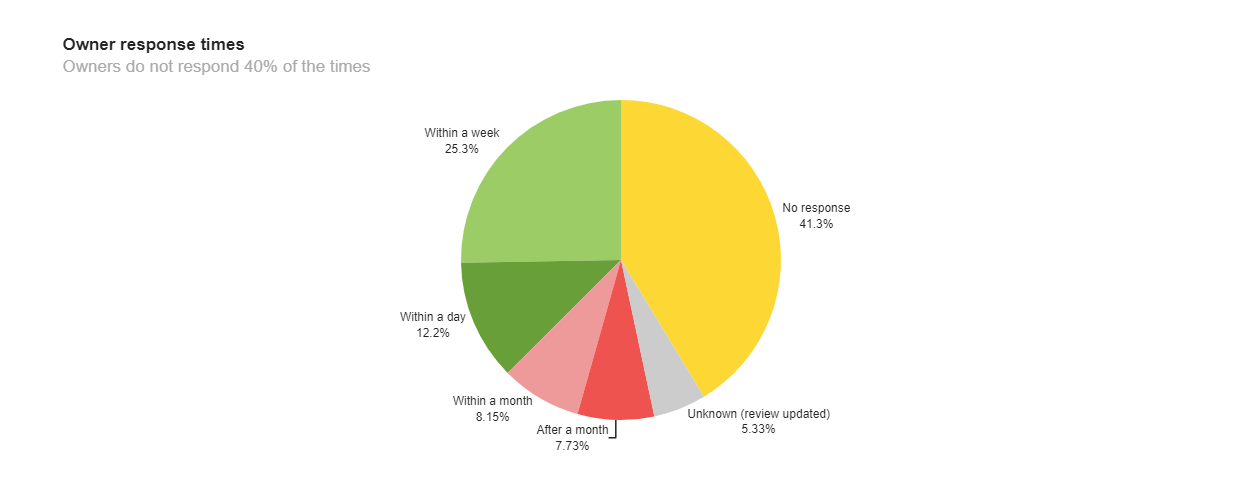

In [21]:
fig = px.pie(
    df_response_time_counts,
    names='response_time',
    values='count',
    title='<b>Owner response times</b><br><span style="color: #aaa;">Owners do not respond 40% of the times</span>',
    height=500,
    template='simple_white',
    color='response_time',
    color_discrete_map={
        "Within a day": "#689F38",
        "No response": "#FDD835",
        "Within a week": "#9CCC65",
        "Within a month": "#EF9A9A",
        "After a month": "#EF5350",
        "Unknown (review updated)": "#ccc"
    },
    labels={
        'response_time': 'Response Time'
    },
)

fig.update_traces(
    textinfo='percent+label',
    textposition='outside',
    showlegend=False
)

fig.update_layout(
    font_family='Helvetica, Inter, Arial, sans-serif',
)

fig.show()

### 👉 Owner's response time (histogram)

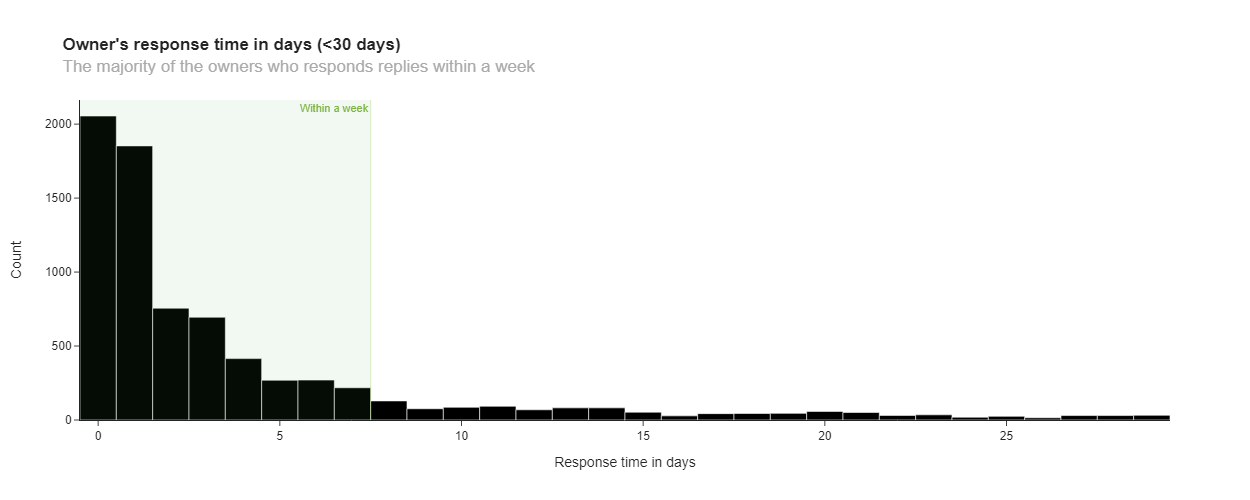

In [22]:
fig = px.histogram(
    df_m[(df_m['response_time_in_days'] >= 0) & (df_m['response_time_in_days'] < 30)],
    x='response_time_in_days',
    template='simple_white',
    title='<b>Owner\'s response time in days (<30 days)</b><br><span style="color: #aaa">The majority of the owners who responds replies within a week</span>',
    height=500,
    labels={
        'response_time_in_days': 'Response time in days'
    },
    color_discrete_sequence=['black']
)

fig.update_layout(
    font_family='Helvetica, Inter, Arial, sans-serif',
    yaxis_title_text='Count'
)

fig.add_vrect(
    x0=-0.5,
    x1=7.5, 
    annotation_text="Within a week",
    annotation_position="top right",
    annotation=dict(
        font_color='#7CB342',
        font_size=11
    ),
    fillcolor="#4CAF50",
    opacity=0.07,
    line_width=0
)
fig.add_vline(x=7.5, line_width=1, line_dash="solid", line_color="#8bc34a")

fig.show()

In [23]:
df_response_sentiment_count =df_m \
    .groupby(['response_time', 'sentiment'], as_index=False) \
    .agg({'review_id': 'count'}) \
    .rename(columns={'review_id': 'count'})

df_response_sentiment_count['sentiment'] = df_response_sentiment_count['sentiment'].str.capitalize()
df_response_sentiment_count['percentage'] = df_response_sentiment_count['count'] / df_response_sentiment_count.groupby('response_time')['count'].transform('sum')

df_response_sentiment_count

response_time sentiment  count  percentage
0              After a month  Negative    507    0.447090
1              After a month  Positive    627    0.552910
2                No response  Negative   2523    0.430326
3                No response  Positive   3340    0.569674
4   Unknown (review updated)  Negative    487    0.570926
5   Unknown (review updated)  Positive    366    0.429074
6               Within a day  Negative    574    0.312807
7               Within a day  Positive   1261    0.687193
8             Within a month  Negative    519    0.411252
9             Within a month  Positive    743    0.588748
10             Within a week  Negative   1275    0.324098
11             Within a week  Positive   2659    0.675902

### 👉 Owner's response time vs sentiment

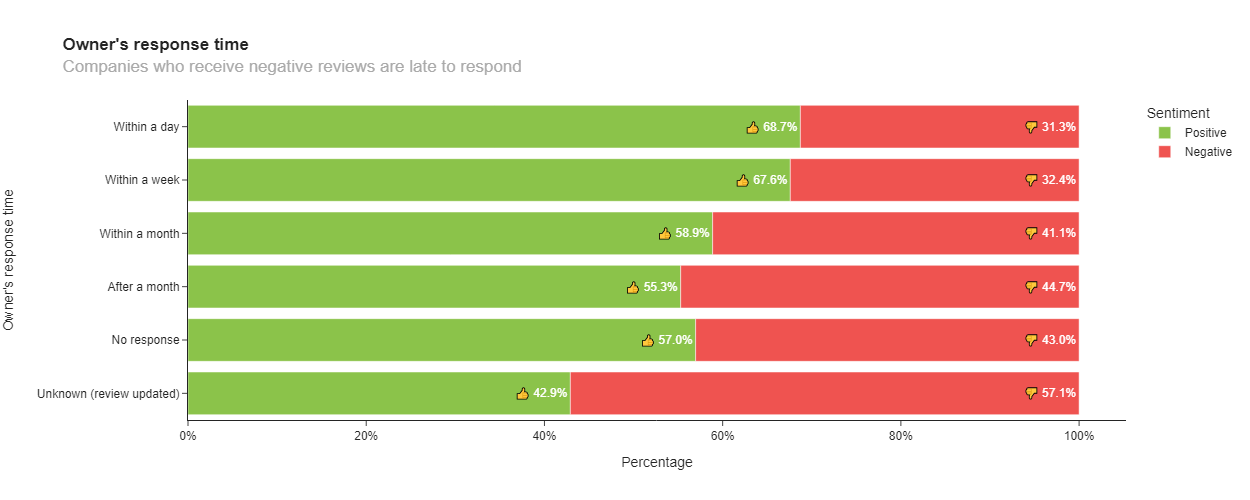

In [24]:
fig = px.bar(
    df_response_sentiment_count,
    x='percentage',
    y='response_time',
    category_orders={
        'response_time': [
            'Within a day',
            'Within a week',
            'Within a month',
            'After a month',
            'No response',
            'Unknown (review updated)'
        ],
        'sentiment': ['Positive', 'Negative']
    },
    template='simple_white',
    color='sentiment',
    color_discrete_map={
        'Positive': '#8bc34a',
        'Negative': '#ef5350'
    },
    labels={'sentiment': 'Sentiment'},
    title='<b>Owner\'s response time</b><br><span style="color: #aaa;">Companies who receive negative reviews are late to respond</span>',
    text=df_response_sentiment_count.apply(lambda r: f"{'👍' if r['sentiment'] == 'Positive' else '👎'} {'{0:.1f}%'.format(r['percentage'] * 100)}", axis=1),
    height=500
)

fig.update_layout(
    xaxis_title_text='Percentage',
    yaxis_title_text='Owner\'s response time',
    font_family='Helvetica, Inter, Arial, sans-serif',
    xaxis_tickformat=',.0%',
)

fig.for_each_trace(lambda t: t.update(textfont_color='white'))

fig.show()

### 👉 Review rating breakdown by campus

In [25]:
df_ratings_breakdown = df_m.groupby(
        ['campus', 'review_rating'],
        as_index=False
    ).agg({
        'review_id': 'count'
    }).rename(columns={
        'review_id': 'num_reviews'
    })

df_ratings_breakdown['campus'] = df_ratings_breakdown['campus'].map({
    'Brigham Young University': 'BYU',
    'Penn State University Park': 'PSU',
    'University of Illinois Urbana-Champaign': 'UIUC'
})

df_ratings_breakdown['review_rating'] = df_ratings_breakdown['review_rating'].astype(str)

df_ratings_breakdown['percentage'] = df_ratings_breakdown['num_reviews'] / df_ratings_breakdown.groupby('campus')['num_reviews'].transform('sum')

df_ratings_breakdown

campus review_rating  num_reviews  percentage
0     BYU             1         1834    0.323971
1     BYU             2          436    0.077018
2     BYU             3          412    0.072779
3     BYU             4         1020    0.180180
4     BYU             5         1959    0.346052
5     PSU             1         1361    0.263606
6     PSU             2          220    0.042611
7     PSU             3          236    0.045710
8     PSU             4          601    0.116405
9     PSU             5         2745    0.531668
10   UIUC             1         1522    0.252572
11   UIUC             2          207    0.034351
12   UIUC             3          176    0.029207
13   UIUC             4          539    0.089446
14   UIUC             5         3582    0.594424

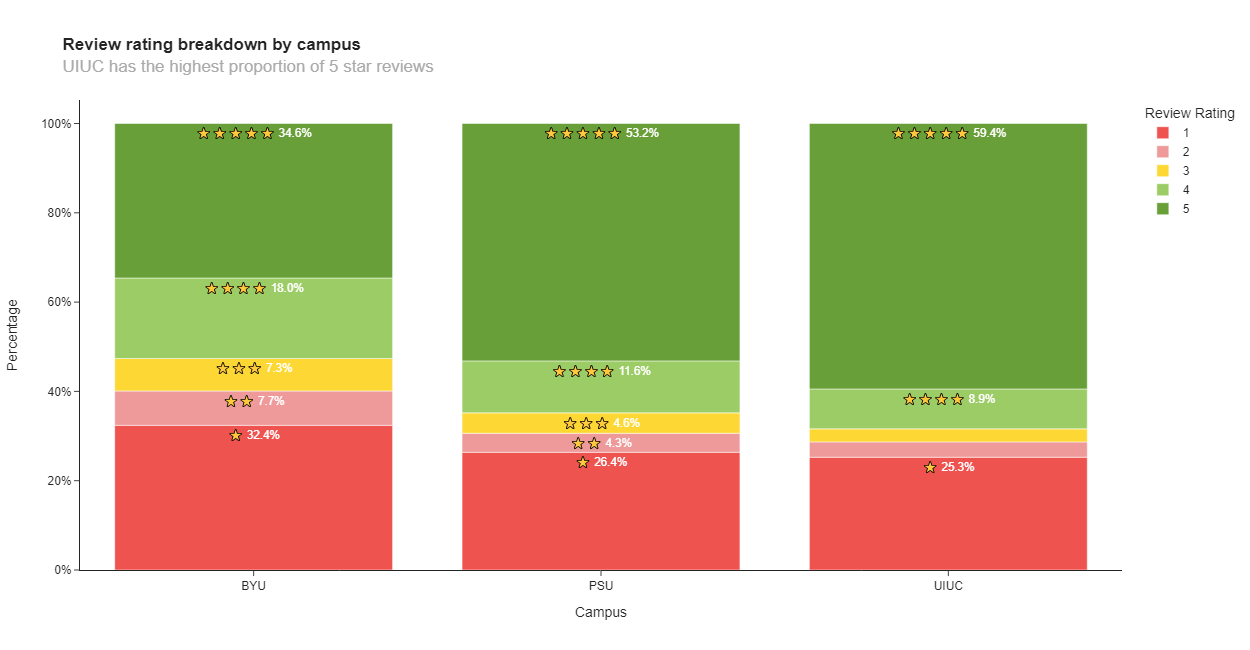

In [26]:
fig = px.bar(
    df_ratings_breakdown,
    x='campus',
    y='percentage',
    color='review_rating',
    color_discrete_map={
        "1": "#EF5350",
        "2": "#EF9A9A",
        "3": "#FDD835",
        "4": "#9CCC65",
        "5": "#689F38"
    },
    labels={
        'review_rating': 'Review Rating',
        'campus': 'Campus',
        'percentage': 'Percentage'
    },
    title='<b>Review rating breakdown by campus</b><br><span style="color: #aaa">UIUC has the highest proportion of 5 star reviews</span>',
    text=df_ratings_breakdown.apply(lambda r: f"{'⭐' * int(r['review_rating'])} {'{0:.1f}%'.format(r['percentage'] * 100)}", axis=1),
    template='simple_white',
    height=650
)

fig.update_layout(
    yaxis_tickformat=',.0%',
    uniformtext_minsize=10,
    uniformtext_mode='hide',
    font_family='Helvetica, Inter, Arial, sans-serif',
)
fig.for_each_trace(lambda t: t.update(textfont_color='white'))

fig.show()

### 👉 Total number of reviews by campus

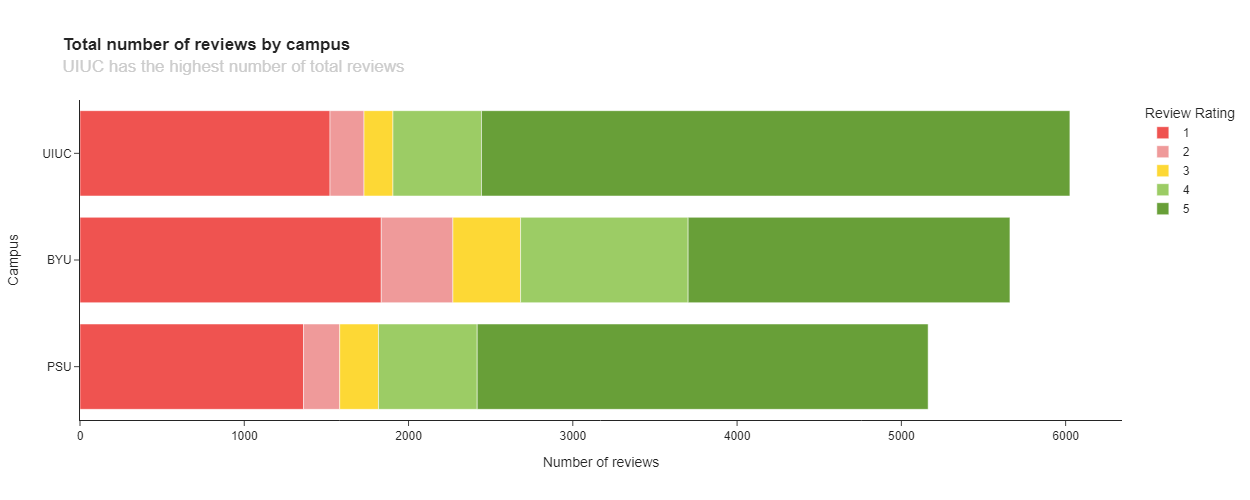

In [27]:
fig = px.bar(
    df_ratings_breakdown,
    x='num_reviews',
    y='campus',
    color='review_rating',
    color_discrete_map={
        "1": "#EF5350",
        "2": "#EF9A9A",
        "3": "#FDD835",
        "4": "#9CCC65",
        "5": "#689F38"
    },
    labels={
        'review_rating': 'Review Rating',
        'campus': 'Campus',
        'percentage': 'Percentage',
        'num_reviews': 'Number of reviews'
    },
    title='<b>Total number of reviews by campus</b><br><span style="color: #ccc;">UIUC has the highest number of total reviews</span>',
    template='simple_white',
    height=500
)

fig.update_layout(
    font_family='Helvetica, Inter, Arial, sans-serif',
)
fig.update_yaxes(categoryorder='total ascending')

fig.show()

### 👉 Review ratings change over time

In [28]:
df_dt = df_m.copy()

df_dt['month'] = df_dt['review_datetime_utc'].dt.strftime('%Y-%m')
df_dt = df_dt[df_dt['review_datetime_utc'].dt.year >= 2015]

df_summary_by_year_month = df_dt.groupby(['month', 'campus'], as_index=False) \
    .agg({
        'review_id': 'count',
        'review_rating': 'mean',
    }) \
    .rename(columns={
        'review_id': 'num_reviews'
    })

df_summary_by_year_month

month                                   campus  num_reviews  \
0    2015-01                 Brigham Young University           27   
1    2015-01               Penn State University Park            6   
2    2015-01  University of Illinois Urbana-Champaign            7   
3    2015-02                 Brigham Young University           21   
4    2015-02               Penn State University Park            8   
..       ...                                      ...          ...   
316  2023-10               Penn State University Park          117   
317  2023-10  University of Illinois Urbana-Champaign          100   
318  2023-11                 Brigham Young University           53   
319  2023-11               Penn State University Park           75   
320  2023-11  University of Illinois Urbana-Champaign           96   

     review_rating  
0         3.222222  
1         2.833333  
2         3.285714  
3         3.428571  
4         2.250000  
..             ...  
316       3.487179  
317       3.070000  
318       3.735849  
319       3.986667  
320       3.916667  

[321 rows x 4 columns]

In [29]:
df_dt = df_m.copy()

df_dt['year'] = df_dt['review_datetime_utc'].dt.year
df_dt = df_dt[df_dt['review_datetime_utc'].dt.year >= 2015]

df_summary_by_year = df_dt.groupby(['year', 'campus'], as_index=False) \
    .agg({
        'review_id': 'count',
        'review_rating': 'mean',
    }) \
    .rename(columns={
        'review_id': 'num_reviews'
    })

df_summary_by_year['campus'] = df_summary_by_year['campus'].map({
    'Brigham Young University': 'BYU',
    'Penn State University Park': 'PSU',
    'University of Illinois Urbana-Champaign': 'UIUC'
})

df_summary_by_year.head(3)

year campus  num_reviews  review_rating
0  2015    BYU          343       3.352770
1  2015    PSU          133       2.729323
2  2015   UIUC          119       3.672269

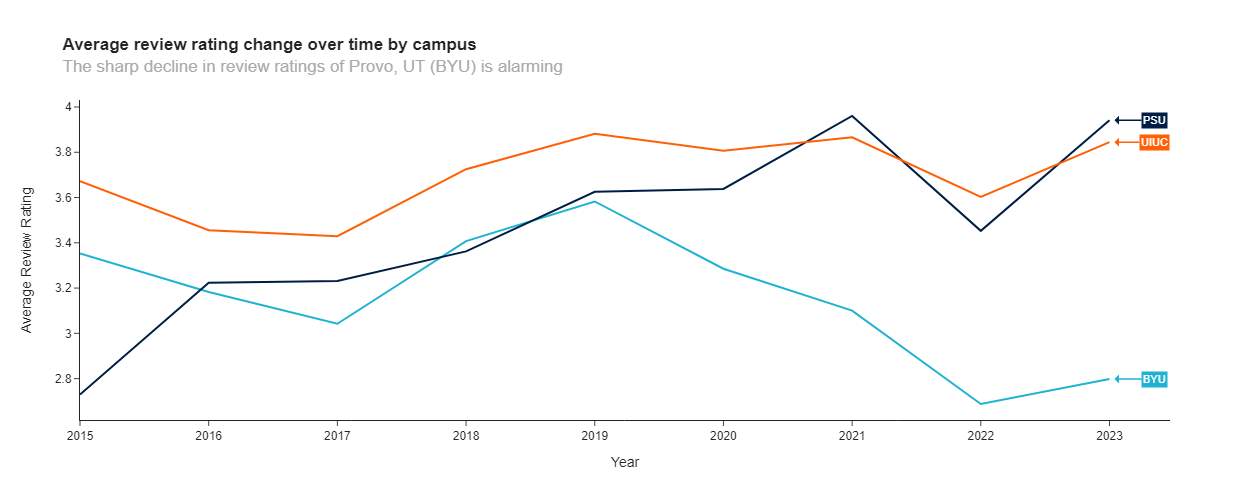

In [30]:
fig = px.line(
    df_summary_by_year,
    x='year',
    y='review_rating',
    color='campus',
    template='simple_white',
    labels={
        'review_rating': 'Average Review Rating',
        'year': 'Year',
        'campus': 'Campus',
    },
    title='<b>Average review rating change over time by campus</b><br><span style="color: #aaa;">The sharp decline in review ratings of Provo, UT (BYU) is alarming</span>',
    color_discrete_map={
        'BYU': '#1FB3D1',
        'PSU': '#001E44',
        'UIUC': '#FF5F05'
    },
    height=500,
)

fig.update_layout(
    font_family='Helvetica, Inter, Arial, sans-serif',
    legend=dict(
        font=dict(
            size=11,
        ),
        yanchor="top",
        y=1,
        xanchor="left",
        x=0.02
    ),
    showlegend=False,
)

annotations = [
    {'bgcolor': '#1FB3D1'},
    {'bgcolor': '#001E44'},
    {'bgcolor': '#FF5F05'},
]

for i in range(df_summary_by_year['campus'].nunique()):
    annotation_year = df_summary_by_year['year'].max()
    campus = df_summary_by_year['campus'].unique()[i]
    y = df_summary_by_year.query(f"(year == {annotation_year}) & (campus == '{campus}')")['review_rating'].iloc[0]
    
    fig.add_annotation(
        x=annotation_year,
        y=y,
        text=campus,
        font=dict(
            color='white',
            size=11
        ),
        showarrow=True,
        arrowwidth=1.5,
        arrowhead=1,
        arrowsize=1,
        arrowcolor=annotations[i]['bgcolor'],
        bgcolor=annotations[i]['bgcolor'],
        xshift=5,
        ax=40,
        ay=0,
    )


fig.show()

### 👉 Positive/negative sentiments by campus

In [31]:
df_sentiment_by_campus = df_m.groupby(['campus', 'sentiment'], as_index=False) \
    .agg({'review_id': 'count'})

df_sentiment_by_campus

campus sentiment  review_id
0                 Brigham Young University  NEGATIVE       2437
1                 Brigham Young University  POSITIVE       2648
2               Penn State University Park  NEGATIVE       1626
3               Penn State University Park  POSITIVE       2855
4  University of Illinois Urbana-Champaign  NEGATIVE       1822
5  University of Illinois Urbana-Champaign  POSITIVE       3493

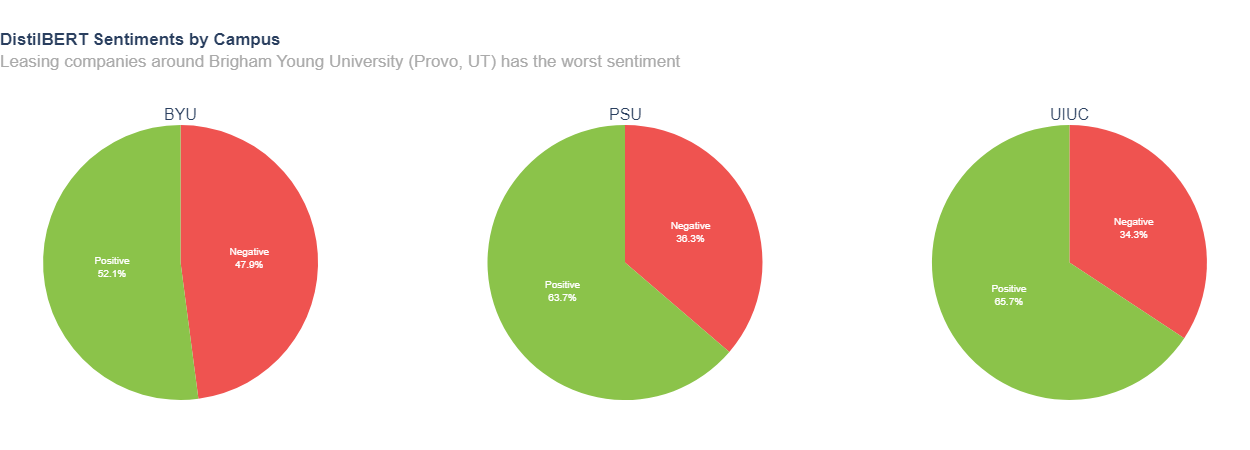

In [32]:
fig = make_subplots(
    rows=1,
    cols=3,
    specs=[[{'type': 'domain'}, {'type': 'domain'}, {'type': 'domain'}]],
    subplot_titles=['BYU', 'PSU', 'UIUC']
)
pie_labels = ['Negative', 'Positive']
marker_colors = ['#ef5350', '#8bc34a']

def add_sentiment_trace(fig, col, campus):
    fig.add_trace(
        go.Pie(
            labels=pie_labels,
            values=df_m[df_m['campus'] == campus]['sentiment'].value_counts().sort_index(),
            text=pie_labels,
            marker_colors=marker_colors,
            textposition='inside',
            textfont=dict(
                size=10,
                color='white'
            ),
            insidetextorientation='horizontal',
            sort=False,
        ), 1, col
    )

add_sentiment_trace(fig, 1, 'Brigham Young University')
add_sentiment_trace(fig, 2, 'Penn State University Park')
add_sentiment_trace(fig, 3, 'University of Illinois Urbana-Champaign')

fig.update_layout(
    title=dict(
        text='<b>DistilBERT Sentiments by Campus</b><br><span style="color: #aaa;">Leasing companies around Brigham Young University (Provo, UT) has the worst sentiment</span>',
        x=0,
        y=0.9,
        xanchor='left',
        yanchor='top',
    ),
    font_family='Helvetica, Arial, Inter, sans-serif',
    showlegend=False,
    margin=dict(
        l=0,
        r=0,
        t=125,
        b=50,
    ),
    height=450
)

In [33]:
df_sentiment_by_campus

campus sentiment  review_id
0                 Brigham Young University  NEGATIVE       2437
1                 Brigham Young University  POSITIVE       2648
2               Penn State University Park  NEGATIVE       1626
3               Penn State University Park  POSITIVE       2855
4  University of Illinois Urbana-Champaign  NEGATIVE       1822
5  University of Illinois Urbana-Champaign  POSITIVE       3493

### 👉 Review length distribution by rating

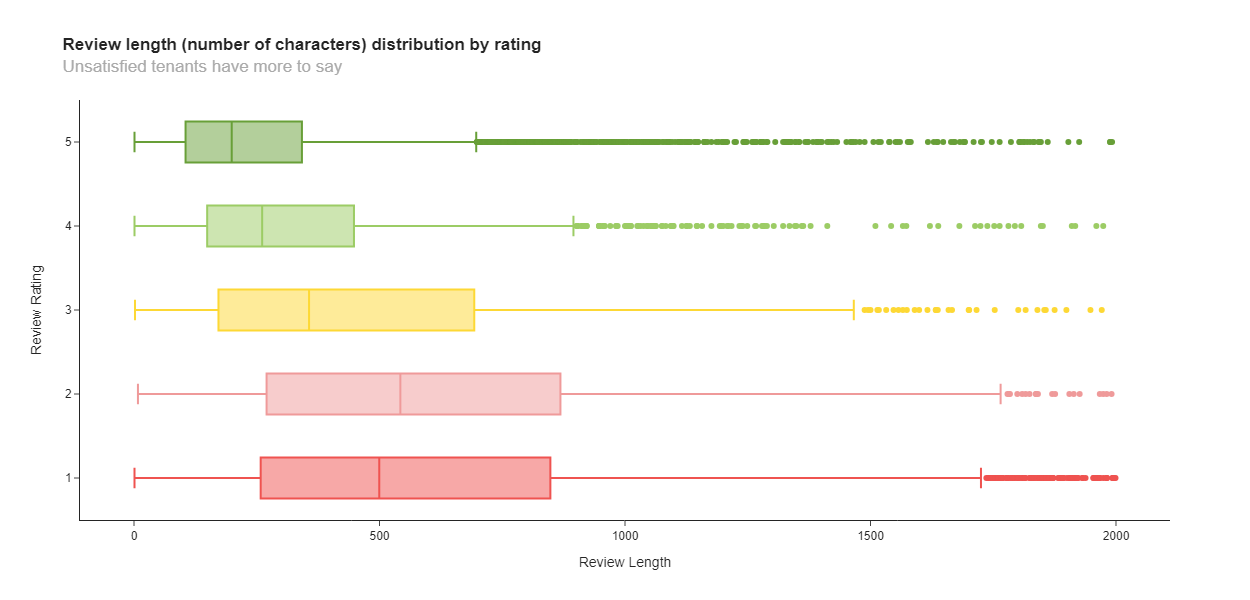

In [34]:
df_review_len = df_m.copy()
df_review_len['review_length'] = df_review_len['review_text'].str.len()
df_review_len['review_rating'] = df_review_len['review_rating'].astype(str)

# only filter review <2000 chars to remove outliers
df_review_len = df_review_len[df_review_len['review_length'] < 2000]

fig = px.box(
    df_review_len,
    x='review_length',
    y='review_rating',
    color='review_rating',
    color_discrete_map={
        "1": "#EF5350",
        "2": "#EF9A9A",
        "3": "#FDD835",
        "4": "#9CCC65",
        "5": "#689F38"
    },
    labels={
        'review_rating': 'Review Rating',
        'review_length': 'Review Length'
    },
    template='simple_white',
    title='<b>Review length (number of characters) distribution by rating</b><br><span style="color: #aaa">Unsatisfied tenants have more to say</span>',
    height=600
)

fig.update_yaxes(categoryorder='category ascending')
fig.update_layout(
    showlegend=False,
    font_family='Helvetica, Inter, Arial, sans-serif',
)

fig.show()

In [35]:
df_m

place_id                             review_id  \
0      ChIJqyXyo6GQTYcRXGfgeIpqc_I  ChdDSUhNMG9nS0VJQ0FnSUQ1OXRHZnNnRRAB   
1      ChIJqyXyo6GQTYcRXGfgeIpqc_I   ChZDSUhNMG9nS0VJQ0FnSUNwOUstOVpBEAE   
2      ChIJqyXyo6GQTYcRXGfgeIpqc_I   ChZDSUhNMG9nS0VJQ0FnSURwbGZXTUJ3EAE   
3      ChIJqyXyo6GQTYcRXGfgeIpqc_I  ChdDSUhNMG9nS0VJQ0FnSURwdzd1Q3B3RRAB   
4      ChIJqyXyo6GQTYcRXGfgeIpqc_I   ChZDSUhNMG9nS0VJQ0FnSURKdnFxeWVnEAE   
...                            ...                                   ...   
16845  ChIJl3GbQTjXDIgRUIdCvHgdOY4   ChZDSUhNMG9nS0VJQ0FnSUNBemFtU2RREAE   
16846  ChIJl3GbQTjXDIgRUIdCvHgdOY4  ChdDSUhNMG9nS0VJQ0FnSURnMWJpZW13RRAB   
16847  ChIJl3GbQTjXDIgRUIdCvHgdOY4   ChZDSUhNMG9nS0VJQ0FnSURROE1id1FnEAE   
16848  ChIJl3GbQTjXDIgRUIdCvHgdOY4   ChZDSUhNMG9nS0VJQ0FnSURnaThIamJ3EAE   
16849  ChIJl3GbQTjXDIgRUIdCvHgdOY4   ChZDSUhNMG9nS0VJQ0FnSURBdHNiMWRnEAE   

                   author_id          author_title  \
0      100512067005706825621           Laura Brown   
1      102936107836751613731        Pete Haraguchi   
2      103835714740882872235          Jack Radford   
3      107352000345615085703        Daniel Merritt   
4      109184252255204802361         Carman Hansen   
...                      ...                   ...   
16845  113313368623391057920  Gabriel Sierra Bello   
16846  103000031950832442884        Iris Hernandez   
16847  100539163977177072418    Muhammad Ali Imran   
16848  116923198120067189398      Alexandra Garcia   
16849  109193350953866618572           Kajal Patel   

                                             review_text  review_rating  \
0      Service requests take a very long time to be r...              3   
1      I was thinking about giving two stars but I le...              1   
2      DO NOT LIVE HERE. This was the WORST experienc...              1   
3      If you have any other choice, take it over Alp...              1   
4      Honestly, I debated whether or not I should le...              1   
...                                                  ...            ...   
16845  I had an emergency because I didn't have a pla...              5   
16846  This is my second time living with CPM. They'r...              5   
16847  Please don't live with CPM. Please just don't ...              1   
16848  I went on a tour of an apartment on Healey, Je...              5   
16849  Campus property management is amazing! Jeremey...              5   

                                          review_img_url  \
0                                                    NaN   
1      https://lh5.googleusercontent.com/p/AF1QipPeIy...   
2                                                    NaN   
3                                                    NaN   
4                                                    NaN   
...                                                  ...   
16845                                                NaN   
16846                                                NaN   
16847                                                NaN   
16848                                                NaN   
16849                                                NaN   

            review_datetime_utc  \
0     2023-10-24 12:46:43+00:00   
1     2023-07-29 20:30:26+00:00   
2     2023-08-26 03:31:42+00:00   
3     2023-08-28 21:54:09+00:00   
4     2023-07-17 21:47:22+00:00   
...                         ...   
16845 2018-01-30 21:32:59+00:00   
16846 2018-05-09 02:30:57+00:00   
16847 2017-12-20 23:05:00+00:00   
16848 2018-05-08 23:14:06+00:00   
16849 2018-02-08 03:10:56+00:00   

                                            owner_answer  \
0      Dear Laura, \n\n We hear you loud and clear, t...   
1      Pete,\n\n Thank you for letting us know about ...   
2      Jack, \n\n I’m so sorry — it sounds like we re...   
3      Daniel,\n\n Even though it was a negative expe...   
4      Dear Carman, \n\n Thank you for bringing this ...   
...                                                  ...   
1

### 👉 Correlation between review length and number of likes

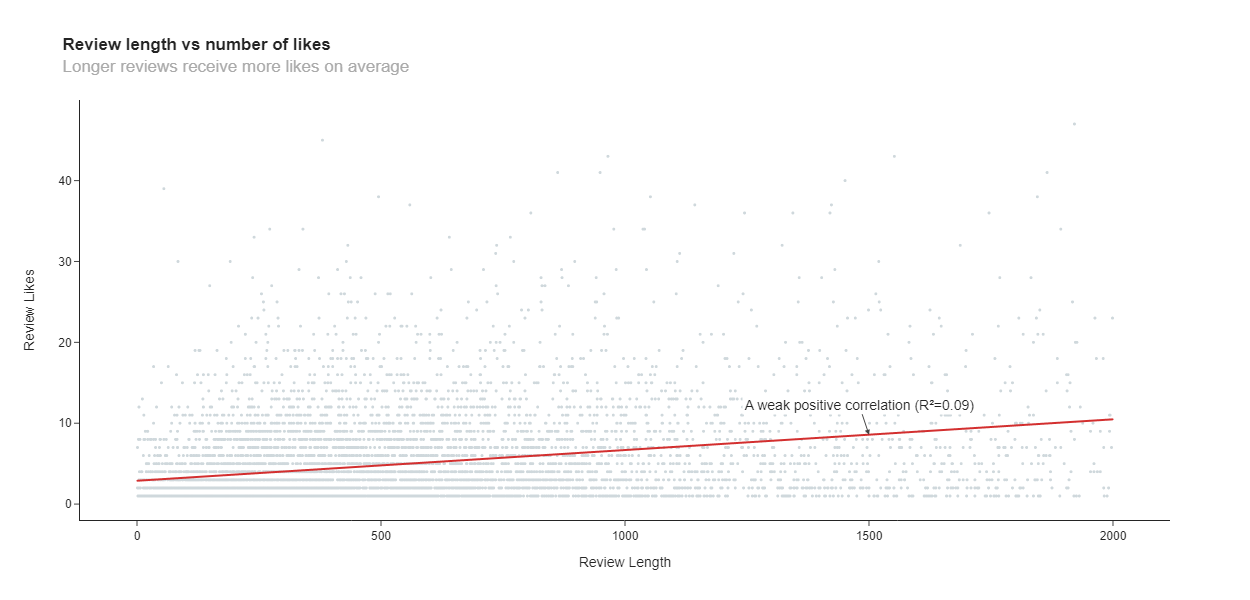

In [36]:
fig = px.scatter(
    df_review_len[df_review_len['review_likes'] > 0],
    x='review_length',
    y='review_likes',
    labels={
        'review_likes': 'Review Likes',
        'review_length': 'Review Length'
    },
    template='simple_white',
    title='<b>Review length vs number of likes</b><br>\
<span style="color: #aaa">Longer reviews receive more likes on average</span>',
    trendline="ols",
    trendline_color_override="#D32F2F",
    height=600
)

fig.update_layout(
    showlegend=False,
    font_family='Helvetica, Inter, Arial, sans-serif',
)

fig.update_traces(
    marker=dict(
        color='#CFD8DC',
        size=3,
    ),
    selector=dict(mode='markers')
)

# calculate y coordinate to add annotation
r = px.get_trendline_results(fig).iloc[0]['px_fit_results'].params
annotation_x = 1500
annotation_y = r[0] + r[1] * annotation_x

fig.add_annotation(
    x=annotation_x,
    y=annotation_y,
    text=f"A weak positive correlation (R²={round(px.get_trendline_results(fig).iloc[0]['px_fit_results'].rsquared, 2)})",
    font=dict(
        size=14
    ),
    showarrow=True,
    arrowhead=2,
    bgcolor='white',
)

fig.show()

## ✏️ Keyword Analysis

### 👉 Frequency of keywords

Convert tokens to lowercase and find frequencies.

In [37]:
df_tokens_lower = df_tokens.copy()
df_tokens_lower['lemma'] = df_tokens_lower['lemma'].str.lower()
df_tokens_lower.rename(columns={'lemma': 'token'}, inplace=True)

df_tokens_lower.head(3)

review_id      text    token    explain
0  ChdDSUhNMG9nS0VJQ0FnSUQ1OXRHZnNnRRAB   Service  service       noun
1  ChdDSUhNMG9nS0VJQ0FnSUQ1OXRHZnNnRRAB  requests  request       noun
2  ChdDSUhNMG9nS0VJQ0FnSUQ1OXRHZnNnRRAB      long     long  adjective

In [38]:
df_token_counts = df_tokens_lower[['review_id', 'token']] \
    .drop_duplicates()['token'] \
    .value_counts() \
    .to_frame() \
    .reset_index() \

df_token_counts

token  count
0             live   6326
1        apartment   6088
2            place   4784
3            great   4206
4             good   3410
...            ...    ...
15269       walkin      1
15270       purple      1
15271       areas/      1
15272  unpredicted      1
15273      jeremey      1

[15274 rows x 2 columns]

In [39]:
df_token_counts.to_csv('tokens-count.csv', index=None)

In [40]:
interesting_keywords = [
    'deposit', 'parking', 'gym', 'internet', 
    'laundry', 'washer', 'leak', 'pool',
    'package', 'expensive', 'maintenance', 'construction',
    'noise', 'pet', 'bug', 'elevator',
]

df_interesting_keywords_count = df_token_counts[
    df_token_counts['token'].isin(interesting_keywords)
]

df_interesting_keywords_count

token  count
7     maintenance   3119
43        parking   1479
80           pool    980
94        deposit    857
126           gym    701
195      internet    471
215       laundry    423
244     expensive    368
296          leak    311
298        washer    309
344       package    269
346      elevator    266
418         noise    216
495           pet    175
544  construction    154
557           bug    148

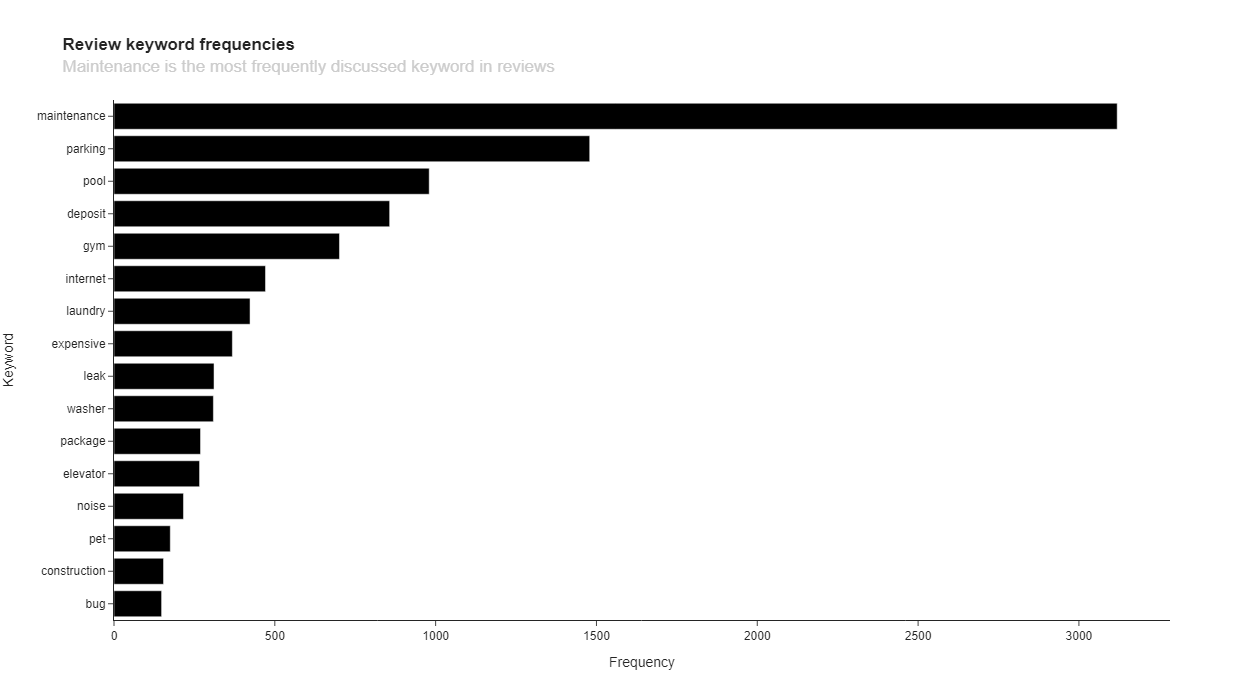

In [41]:
fig = px.bar(
    df_interesting_keywords_count,
    x='count',
    y='token',
    labels={
        'token': 'Keyword',
        'count': 'Frequency',
    },
    title='<b>Review keyword frequencies</b><br><span style="color: #ccc;">Maintenance is the most frequently discussed keyword in reviews</span>',
    template='simple_white',
    height=700
)

fig.update_layout(
    font_family='Helvetica, Inter, Arial, sans-serif',
)
fig.update_traces(marker_color='black')
fig.update_yaxes(categoryorder='total ascending')

fig.show()

### 👉 Positive/negative associations with tokens

Convert tokens to lowercase and find frequencies.

In [42]:
df_interesting_tokens = df_tokens_lower[df_tokens_lower['token'].isin(interesting_keywords)]

df_interesting_token_sentiments = pd.merge(
    left=df_r[['place_id', 'review_id', 'sentiment']],
    right=df_interesting_tokens[['review_id', 'token']],
    how='inner',
    on='review_id'
)

df_interesting_token_sentiments

place_id                             review_id  \
0      ChIJqyXyo6GQTYcRXGfgeIpqc_I  ChdDSUhNMG9nS0VJQ0FnSUQ1OXRHZnNnRRAB   
1      ChIJqyXyo6GQTYcRXGfgeIpqc_I   ChZDSUhNMG9nS0VJQ0FnSUNwOUstOVpBEAE   
2      ChIJqyXyo6GQTYcRXGfgeIpqc_I   ChZDSUhNMG9nS0VJQ0FnSUNwOUstOVpBEAE   
3      ChIJqyXyo6GQTYcRXGfgeIpqc_I   ChZDSUhNMG9nS0VJQ0FnSUNwOUstOVpBEAE   
4      ChIJqyXyo6GQTYcRXGfgeIpqc_I   ChZDSUhNMG9nS0VJQ0FnSUNwOUstOVpBEAE   
...                            ...                                   ...   
13535  ChIJl3GbQTjXDIgRUIdCvHgdOY4   ChZDSUhNMG9nS0VJQ0FnSUNneXJ6aEJ3EAE   
13536  ChIJl3GbQTjXDIgRUIdCvHgdOY4   ChZDSUhNMG9nS0VJQ0FnSURBcXJXekJ3EAE   
13537  ChIJl3GbQTjXDIgRUIdCvHgdOY4   ChZDSUhNMG9nS0VJQ0FnSUMwMklTakh3EAE   
13538  ChIJl3GbQTjXDIgRUIdCvHgdOY4   ChZDSUhNMG9nS0VJQ0FnSURJeVplTGZ3EAE   
13539  ChIJl3GbQTjXDIgRUIdCvHgdOY4  ChdDSUhNMG9nS0VJQ0FnSUNzdktudTV3RRAB   

      sentiment        token  
0      POSITIVE         pool  
1      NEGATIVE     elevator  
2      NEGATIVE     elevator  
3      NEGATIVE          gym  
4      NEGATIVE      parking  
...         ...          ...  
13535  NEGATIVE  maintenance  
13536  POSITIVE      deposit  
13537  POSITIVE  maintenance  
13538  POSITIVE  maintenance  
13539  POSITIVE         leak  

[13540 rows x 4 columns]

In [43]:
df_interesting_token_sentiment_counts = df_interesting_token_sentiments \
    .groupby(['token', 'sentiment'], as_index=False) \
    .agg({'review_id': 'count'}) \
    .rename(columns={'review_id': 'count'})

df_interesting_token_sentiment_counts['percentage'] = df_interesting_token_sentiment_counts['count'] / df_interesting_token_sentiment_counts.groupby('token')['count'].transform('sum')
df_interesting_token_sentiment_counts['sentiment'] = df_interesting_token_sentiment_counts['sentiment'].str.capitalize()
df_interesting_token_sentiment_counts.sort_values(
    ['sentiment', 'percentage'],
    ascending=[True, True],
    inplace=True
)

df_interesting_token_sentiment_counts.head(10)

token sentiment  count  percentage
10          gym  Negative    231    0.304348
28         pool  Negative    469    0.421384
26          pet  Negative    101    0.431624
18  maintenance  Negative   1901    0.478600
30       washer  Negative    225    0.616438
14      laundry  Negative    323    0.625969
8     expensive  Negative    246    0.629156
22      package  Negative    261    0.659091
24      parking  Negative   1607    0.667914
20        noise  Negative    205    0.729537

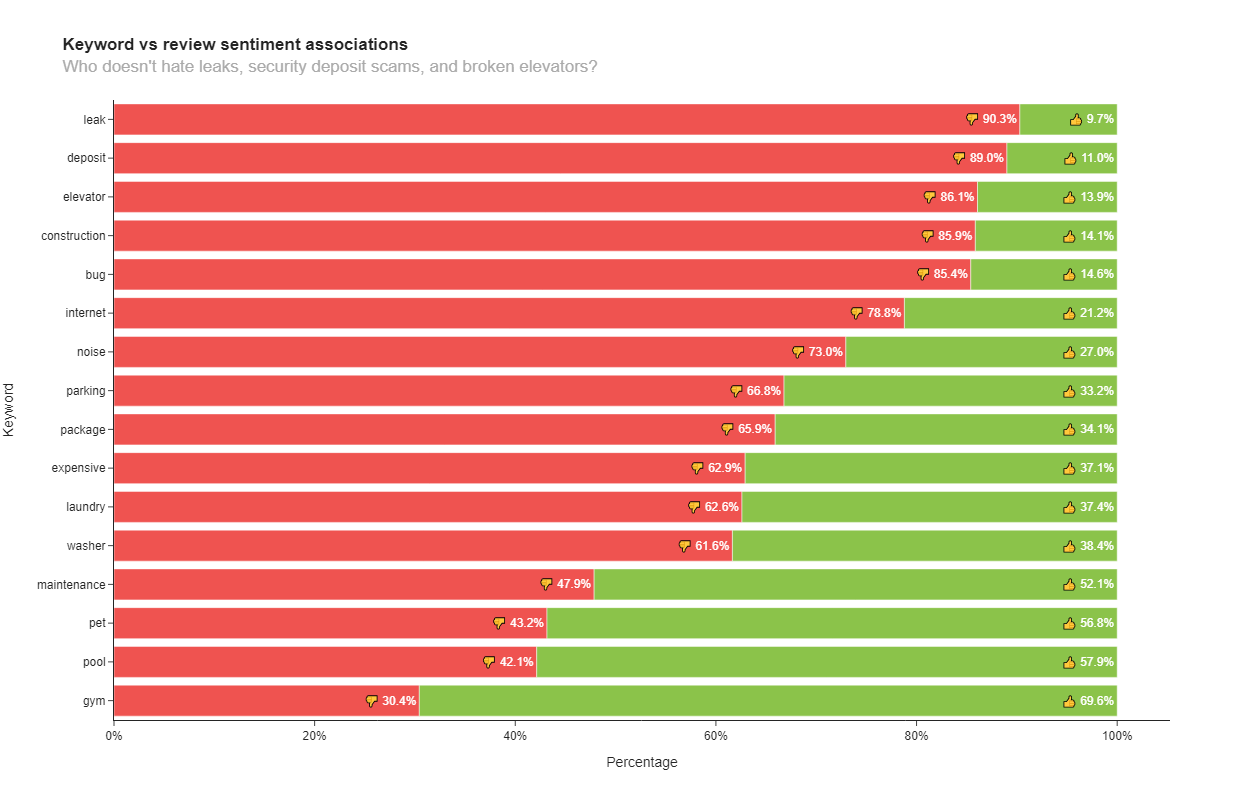

In [44]:
fig = px.bar(
    df_interesting_token_sentiment_counts,
    x='percentage',
    y='token',
    template='simple_white',
    color='sentiment',
    color_discrete_map={
        'Positive': '#8bc34a',
        'Negative': '#ef5350'
    },
    labels={'token': 'Keyword', 'sentiment': 'Sentiment', 'percentage': 'Percentage'},
    title='<b>Keyword vs review sentiment associations</b><br><span style="color: #aaa;">Who doesn\'t hate leaks, security deposit scams, and broken elevators?</span>',
    text=df_interesting_token_sentiment_counts.apply(lambda r: f"{'👍' if r['sentiment'] == 'Positive' else '👎'} {'{0:.1f}%'.format(r['percentage'] * 100)}", axis=1),
    height=800
)

fig.update_layout(
    font_family='Helvetica, Inter, Arial, sans-serif',
    xaxis_tickformat=',.0%',
    showlegend=False,
)

fig.for_each_trace(lambda t: t.update(textfont_color='white'))

fig.show()

In [45]:
df_tokens_places = pd.merge(
    left=df_interesting_token_sentiments.drop_duplicates()[['place_id', 'sentiment', 'token']],
    right=df_b[['place_id', 'name', 'campus']]
)

df_tokens_places

place_id sentiment        token  \
0      ChIJqyXyo6GQTYcRXGfgeIpqc_I  POSITIVE         pool   
1      ChIJqyXyo6GQTYcRXGfgeIpqc_I  NEGATIVE     elevator   
2      ChIJqyXyo6GQTYcRXGfgeIpqc_I  NEGATIVE          gym   
3      ChIJqyXyo6GQTYcRXGfgeIpqc_I  NEGATIVE      parking   
4      ChIJqyXyo6GQTYcRXGfgeIpqc_I  NEGATIVE       washer   
...                            ...       ...          ...   
10241  ChIJl3GbQTjXDIgRUIdCvHgdOY4  NEGATIVE  maintenance   
10242  ChIJl3GbQTjXDIgRUIdCvHgdOY4  POSITIVE      deposit   
10243  ChIJl3GbQTjXDIgRUIdCvHgdOY4  POSITIVE  maintenance   
10244  ChIJl3GbQTjXDIgRUIdCvHgdOY4  POSITIVE  maintenance   
10245  ChIJl3GbQTjXDIgRUIdCvHgdOY4  POSITIVE         leak   

                                name                                   campus  
0                     Alpine Village                 Brigham Young University  
1                     Alpine Village                 Brigham Young University  
2                     Alpine Village                 Brigham Young University  
3                     Alpine Village                 Brigham Young University  
4                     Alpine Village                 Brigham Young University  
...                              ...                                      ...  
10241  Community Property Management  University of Illinois Urbana-Champaign  
10242  Community Property Management  University of Illinois Urbana-Champaign  
10243  Community Property Management  University of Illinois Urbana-Champaign  
10244  Community Property Management  University of Illinois Urbana-Champaign  
10245  Community Property Management  University of Illinois Urbana-Champaign  

[10246 rows x 5 columns]

Get the number of reviews by each business.

In [46]:
df_place_review_counts = df_r[df_r['review_text'].notna()].groupby('place_id', as_index=False)['review_id'].count() \
    .rename(columns={'review_id': 'num_reviews'})

df_place_review_counts

place_id  num_reviews
0    ChIJ06hDonPXDIgRwvaC5IF3CaA           35
1    ChIJ08JvZlGXTYcRYhauVfCCuJk           78
2    ChIJ0yehl6XXDIgRtqPdtmcuKeU           17
3    ChIJ28QMEbyozokRvv0bOBv6TUc          161
4    ChIJ2ZFgr_GlzokRlEdDJIv3WFU           26
..                           ...          ...
137  ChIJvzfjLA2XTYcR66z_4bzQOvY           48
138  ChIJw3E2MbKQTYcRswRvHD7LBaU          200
139  ChIJy6xaEQapzokRGunpHg5WWxk          200
140  ChIJywqAqaCozokRRoRR_ZhhcQ8           30
141  ChIJzZZ2J46ozokRTALobuh-_JA           34

[142 rows x 2 columns]

In [47]:
df_tokens_places_summary = df_tokens_places.groupby(['place_id', 'name', 'campus', 'token'], as_index=False) \
    .agg({'sentiment': 'size'}) \
    .rename(columns={'sentiment': 'unique_frequency'}) \
    .merge(
        right=df_place_review_counts,
        on='place_id'
    )

df_tokens_places_summary['percentage'] = df_tokens_places_summary['unique_frequency'] / df_tokens_places_summary['num_reviews']
df_tokens_places_summary = df_tokens_places_summary[df_tokens_places_summary['percentage'] >= 0.1]
df_tokens_places_summary.sort_values('percentage', ascending=False)

place_id  \
756   ChIJX_L4rUnXDIgR9TAeTC_hgXA   
1227  ChIJn4wFUb-ozokRBIjeH4SwQl0   
555   ChIJLS5X17OnzokRqWLyrt6auaM   
391   ChIJFws_9NCnzokRWuhhIW9H3ro   
785   ChIJZ1Wg5rDXDIgRwsRBDwZ_PUw   
...                           ...   
1269  ChIJpbSzGKyQTYcRh9jrNYBP-fg   
1081  ChIJhVL1izfXDIgRk7TCCsdAoJg   
1241  ChIJoUKqgmHXDIgRrZiClSE_GkA   
866   ChIJ_xPJJp6QTYcRtK0Q5z9fkaA   
1209  ChIJm0H0xraQTYcR3_G-7MOct8c   

                                               name  \
756                                University Group   
1227                          Lions Gate Apartments   
555   Toftrees Apartments - Turtle Creek Apartments   
391                             The Bryn Apartments   
785                             Parkside Apartments   
...                                             ...   
1269                                    FCS Rentals   
1081                            Latitude Apartments   
1241                                       The Linc   
866                                    The Branbury   
1209                        Campus Plaza Apartments   

                                       campus        token  unique_frequency  \
756   University of Illinois Urbana-Champaign  maintenance               115   
1227               Penn State University Park  maintenance                12   
555                Penn State University Park  maintenance                13   
391                Penn State University Park  maintenance                87   
785   University of Illinois Urbana-Champaign  maintenance                19   
...                                       ...          ...               ...   
1269                 Brigham Young University  maintenance                 9   
1081  University of Illinois Urbana-Champaign         pool                20   
1241  University of Illinois Urbana-Champaign          gym                20   
866                  Brigham Young University      laundry                20   
1209                 Brigham Young University         pool                 5   

      num_reviews  percentage  
756           200    0.575000  
1227           21    0.571429  
555            24    0.541667  
391           200    0.435000  
785            45    0.422222  
...           ...         ...  
1269           90    0.100000  
1081          200    0.100000  
1241          200    0.100000  
866           200    0.100000  
1209           50    0.100000  

[294 rows x 7 columns]

In [48]:
df_keyword_deposit = df_tokens_places_summary[df_tokens_places_summary['token'] \
    .isin(['deposit'])] \
    .sort_values('percentage', ascending=False) \
    .head(8)

df_keyword_deposit

place_id                                name  \
750   ChIJX_L4rUnXDIgR9TAeTC_hgXA                    University Group   
830   ChIJ_6ilhpCozokRsa-n2GaKOok         Westside Village Apartments   
984   ChIJc3JrGwOmzokRl_jsCCW171A       University Terrace Apartments   
848   ChIJ_wceM3SaTYcR5NSItFkWLm4            Carriage Cove Apartments   
1211  ChIJm34mnaCozokRBrvtNNK75Fg                 The Apartment Store   
185   ChIJ7R36jEbXDIgRE_nknCuwSNY                      MHM Properties   
1231  ChIJoSr7t0yXTYcR8NrNNAdufq0              East Pointe Apartments   
666   ChIJTf00b6KozokR3Z7Dfnj4ZXo  Continental Real Estate Mgmt, Inc.   

                                       campus    token  unique_frequency  \
750   University of Illinois Urbana-Champaign  deposit                79   
830                Penn State University Park  deposit                19   
984                Penn State University Park  deposit                 8   
848                  Brigham Young University  deposit                34   
1211               Penn State University Park  deposit                18   
185   University of Illinois Urbana-Champaign  deposit                10   
1231                 Brigham Young University  deposit                 4   
666                Penn State University Park  deposit                35   

      num_reviews  percentage  
750           200    0.395000  
830            73    0.260274  
984            34    0.235294  
848           161    0.211180  
1211           86    0.209302  
185            52    0.192308  
1231           22    0.181818  
666           200    0.175000

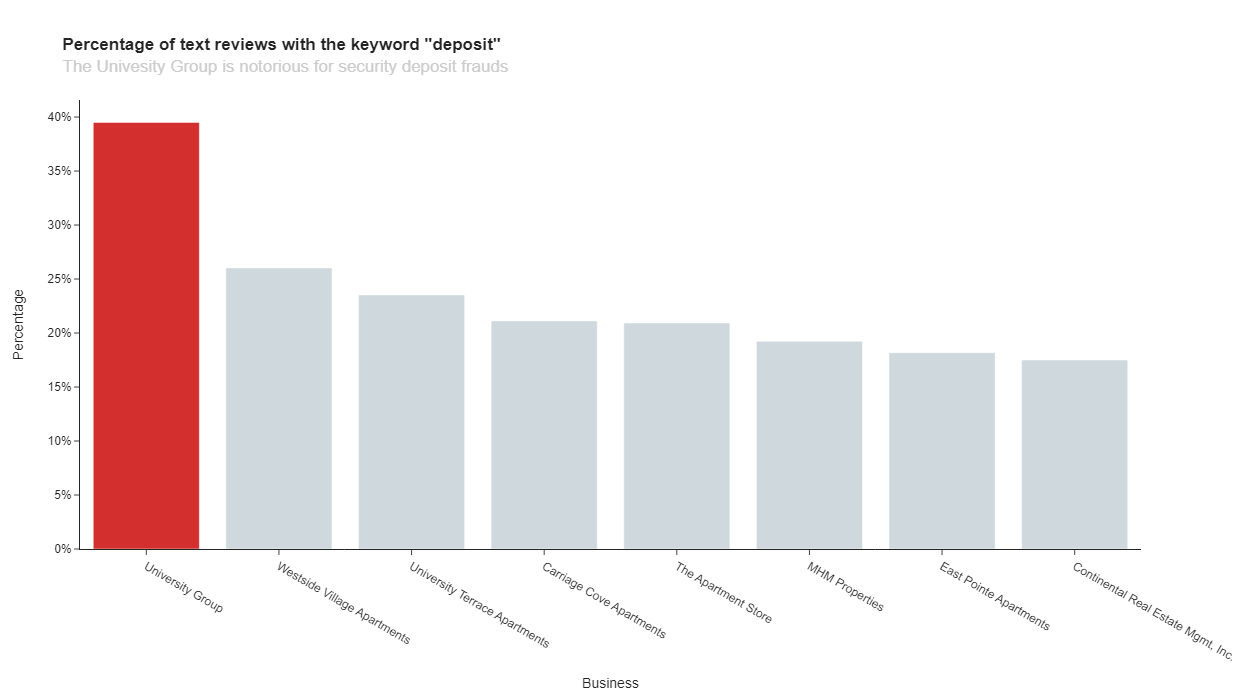

In [49]:
color_discrete_sequence = ['#cfd8dc'] * df_keyword_deposit.shape[0]
color_discrete_sequence[0] = '#d32f2f'

fig = px.bar(
    df_keyword_deposit,
    x='name',
    y='percentage',
    labels={
        'name': 'Business',
        'percentage': 'Percentage',
    },
    title='<b>Percentage of text reviews with the keyword "deposit"</b><br><span style="color: #ccc;">The Univesity Group is notorious for security deposit frauds</span>',
    template='simple_white',
    color='name',
    color_discrete_sequence=color_discrete_sequence,
    height=700
)

fig.update_layout(
    yaxis_tickformat=',.0%',
    font_family='Helvetica, Inter, Arial, sans-serif',
    showlegend=False,
)
# fig.update_traces(marker_color='black')


fig.show()

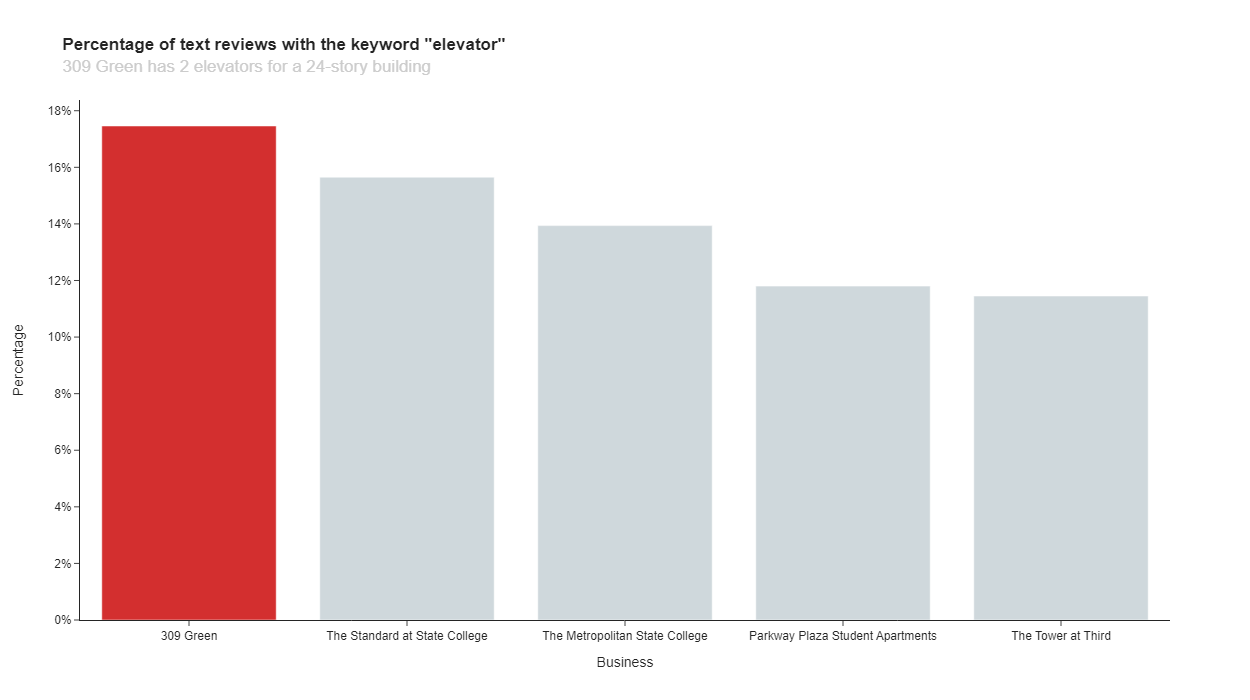

In [50]:
df_keyword_deposit = df_tokens_places_summary[df_tokens_places_summary['token'] \
    .isin(['elevator'])] \
    .sort_values('percentage', ascending=False) \
    .head(8)

df_keyword_deposit

color_discrete_sequence = ['#cfd8dc'] * df_keyword_deposit.shape[0]
color_discrete_sequence[0] = '#d32f2f'

fig = px.bar(
    df_keyword_deposit,
    x='name',
    y='percentage',
    labels={
        'name': 'Business',
        'percentage': 'Percentage',
    },
    title='<b>Percentage of text reviews with the keyword "elevator"</b><br><span style="color: #ccc;">309 Green has 2 elevators for a 24-story building</span>',
    template='simple_white',
    color='name',
    color_discrete_sequence=color_discrete_sequence,
    height=700
)

fig.update_layout(
    yaxis_tickformat=',.0%',
    font_family='Helvetica, Inter, Arial, sans-serif',
    showlegend=False,
)
# fig.update_traces(marker_color='black')


fig.show()

### 👉 Percentage of tokens by campus

Get the number of reviews with review text by each campus.

In [51]:
df_campus_review_counts = df_m[df_m['review_text'].notna()].groupby('campus', as_index=False)['review_id'].count() \
    .rename(columns={'review_id': 'num_reviews'})

df_campus_review_counts

campus  num_reviews
0                 Brigham Young University         5085
1               Penn State University Park         4481
2  University of Illinois Urbana-Champaign         5315

In [52]:
df_tokens_campus_summary = df_tokens_places.groupby(['campus', 'token'], as_index=False) \
    .agg({'sentiment': 'size'}) \
    .rename(columns={'sentiment': 'unique_frequency'}) \
    .merge(
        right=df_campus_review_counts,
        on='campus'
    )

df_tokens_campus_summary['percentage'] = df_tokens_campus_summary['unique_frequency'] / df_tokens_campus_summary['num_reviews']
df_tokens_campus_summary['campus'] = df_tokens_campus_summary['campus'].map({
    'Brigham Young University': 'BYU',
    'Penn State University Park': 'PSU',
    'University of Illinois Urbana-Champaign': 'UIUC'
})
df_tokens_campus_summary.sort_values(['campus', 'token'], inplace=True)
df_tokens_campus_summary.head()

campus         token  unique_frequency  num_reviews  percentage
0    BYU           bug                59         5085    0.011603
1    BYU  construction                48         5085    0.009440
2    BYU       deposit               364         5085    0.071583
3    BYU      elevator                36         5085    0.007080
4    BYU     expensive               228         5085    0.044838

In [53]:
df_campus_positive_keywords = df_tokens_campus_summary[df_tokens_campus_summary['token'] \
    .isin(['gym', 'pool', 'pet'])] \
    .sort_values(['campus', 'token'])

df_campus_positive_keywords.head(3)

campus token  unique_frequency  num_reviews  percentage
5     BYU   gym               191         5085    0.037561
13    BYU   pet                35         5085    0.006883
14    BYU  pool               526         5085    0.103441

In [54]:
df_campus_negative_keywords = df_tokens_campus_summary[df_tokens_campus_summary['token'] \
    .isin(['leak', 'deposit', 'elevator'])] \
    .sort_values(['campus', 'token'])

df_campus_negative_keywords.head(3)

campus     token  unique_frequency  num_reviews  percentage
2    BYU   deposit               364         5085    0.071583
3    BYU  elevator                36         5085    0.007080
8    BYU      leak               125         5085    0.024582

In [55]:
df_campus_misc_keywords = df_tokens_campus_summary[df_tokens_campus_summary['token'] \
    .isin(['parking', 'expensive', 'construction', 'package'])] \
    .sort_values(['campus', 'token'])

df_campus_misc_keywords.head(3)

campus         token  unique_frequency  num_reviews  percentage
1     BYU  construction                48         5085    0.009440
4     BYU     expensive               228         5085    0.044838
11    BYU       package                61         5085    0.011996

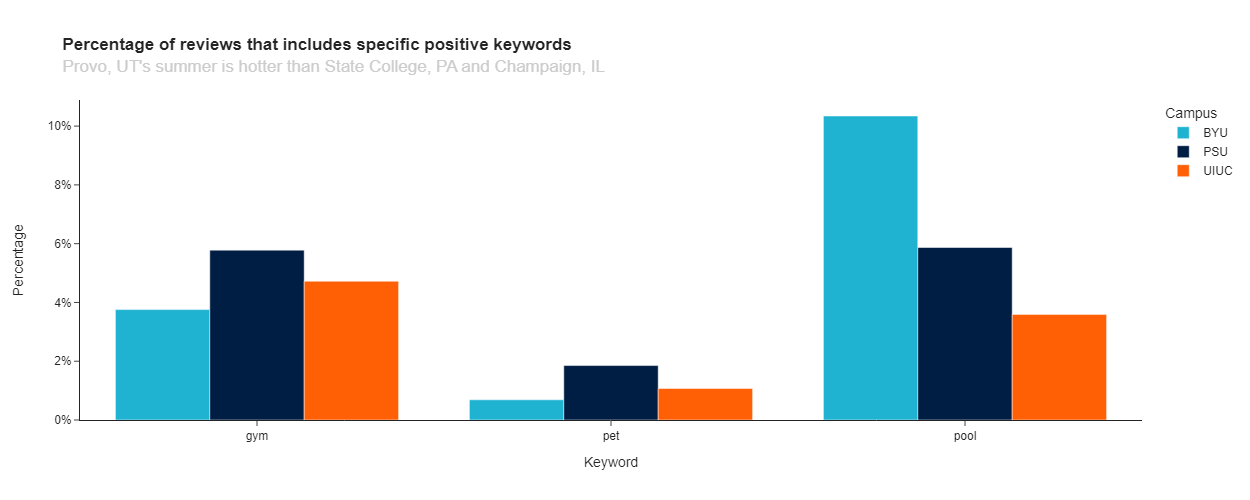

In [56]:
fig = px.bar(
    df_campus_positive_keywords,
    x='token',
    y='percentage',
    color='campus',
    color_discrete_map={
        'BYU': '#1FB3D1',
        'PSU': '#001E44',
        'UIUC': '#FF5F05'
    },
    title='<b>Percentage of reviews that includes specific positive keywords</b><br>\
<span style="color: #ccc;">Provo, UT\'s summer is hotter than State College, PA and Champaign, IL</span>',
    labels={
        'percentage': 'Percentage',
        'token': 'Keyword',
        'campus': 'Campus'
    },
    height=500,
    template='simple_white',
    barmode='group'
)

fig.update_layout(
    yaxis_tickformat=',.0%',
    font_family='Helvetica, Inter, Arial, sans-serif',
)

fig.show()

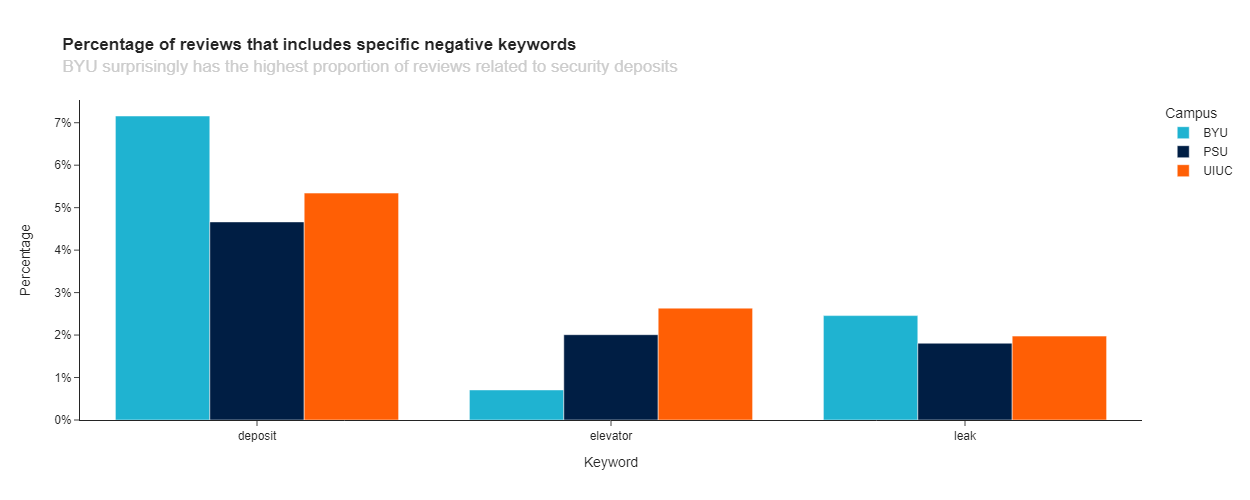

In [57]:
fig = px.bar(
    df_campus_negative_keywords,
    x='token',
    y='percentage',
    color='campus',
    color_discrete_map={
        'BYU': '#1FB3D1',
        'PSU': '#001E44',
        'UIUC': '#FF5F05'
    },
    title='<b>Percentage of reviews that includes specific negative keywords</b><br>\
<span style="color: #ccc;">BYU surprisingly has the highest proportion of reviews related to security deposits</span>',
    labels={
        'percentage': 'Percentage',
        'token': 'Keyword',
        'campus': 'Campus'
    },
    height=500,
    template='simple_white',
    barmode='group'
)

fig.update_layout(
    yaxis_tickformat=',.0%',
    font_family='Helvetica, Inter, Arial, sans-serif',
)

fig.show()

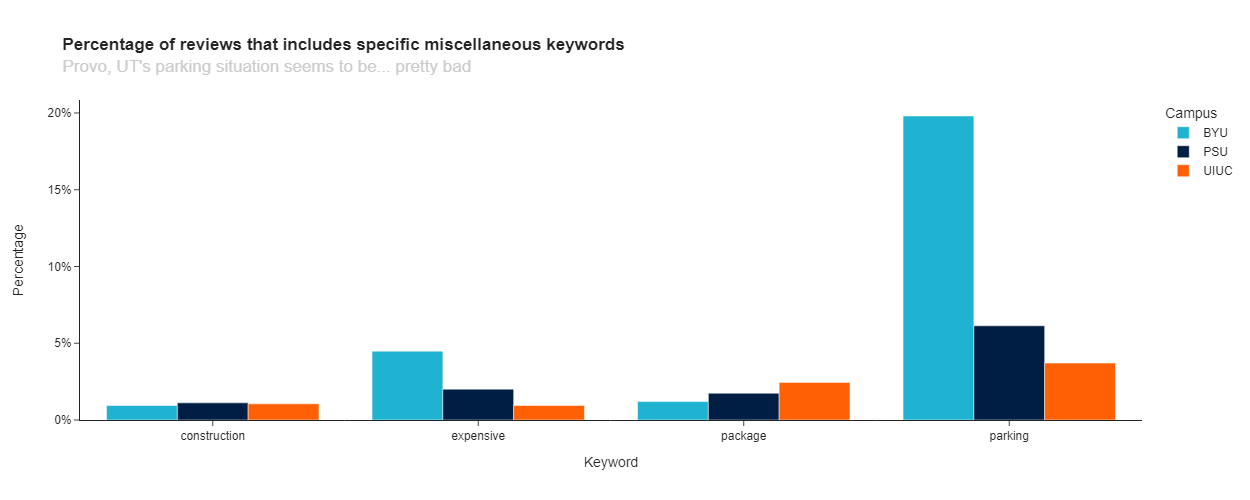

In [58]:
fig = px.bar(
    df_campus_misc_keywords,
    x='token',
    y='percentage',
    color='campus',
    color_discrete_map={
        'BYU': '#1FB3D1',
        'PSU': '#001E44',
        'UIUC': '#FF5F05'
    },
    title='<b>Percentage of reviews that includes specific miscellaneous keywords</b><br>\
<span style="color: #ccc;">Provo, UT\'s parking situation seems to be... pretty bad</span>',
    labels={
        'percentage': 'Percentage',
        'token': 'Keyword',
        'campus': 'Campus'
    },
    height=500,
    template='simple_white',
    barmode='group'
)

fig.update_layout(
    yaxis_tickformat=',.0%',
    font_family='Helvetica, Inter, Arial, sans-serif',
)

fig.show()